In [9]:
import tensorflow as tf

In [10]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=2880):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

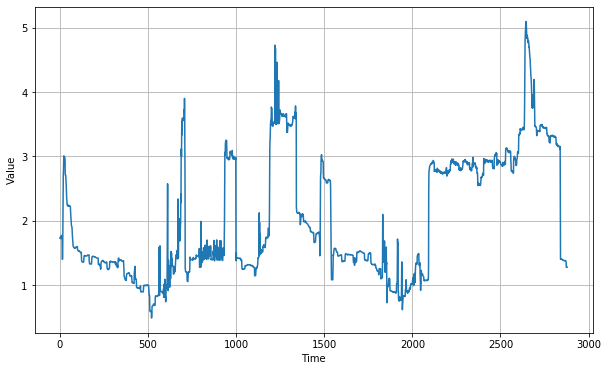

In [11]:
import csv
time_step = []
temps = []

with open("House1.csv") as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    step=0
    for row in reader:
        temps.append(float(row[1]))
        time_step.append(step)
        step = step + 1

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [13]:
split_time = 1440
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [14]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [15]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [16]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(1440,)
Epoch 1/100
6/6 [==============================] - 12s 2s/step - loss: 2.4458 - mae: 2.9270
Epoch 2/100
6/6 [==============================] - 3s 471ms/step - loss: 2.4026 - mae: 2.8848
Epoch 3/100
6/6 [==============================] - 3s 473ms/step - loss: 2.3327 - mae: 2.8155
Epoch 4/100
6/6 [==============================] - 3s 470ms/step - loss: 2.2572 - mae: 2.7293
Epoch 5/100
6/6 [==============================] - 4s 621ms/step - loss: 2.1773 - mae: 2.6330
Epoch 6/100
6/6 [==============================] - 3s 515ms/step - loss: 2.0856 - mae: 2.5326
Epoch 7/100
6/6 [==============================] - 3s 473ms/step - loss: 1.9634 - mae: 2.4391
Epoch 8/100
6/6 [==============================] - 3s 468ms/step - loss: 1.8868 - mae: 2.3507
Epoch 9/100
6/6 [==============================] - 3s 469ms/step - loss: 1.8233 - mae: 2.2763
Epoch 10/100
6/6 [==============================] - 3s

[1e-08, 0.0001, 0, 60]

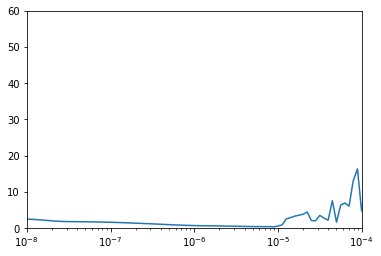

In [17]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [18]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=150)

Epoch 1/150
14/14 [==============================] - 11s 782ms/step - loss: 4.9272 - mae: 5.3963
Epoch 2/150
14/14 [==============================] - 4s 281ms/step - loss: 1.5127 - mae: 1.8963
Epoch 3/150
14/14 [==============================] - 4s 255ms/step - loss: 0.4981 - mae: 0.9519
Epoch 4/150
14/14 [==============================] - 4s 271ms/step - loss: 2.6502 - mae: 3.1434
Epoch 5/150
14/14 [==============================] - 4s 293ms/step - loss: 1.4354 - mae: 1.8873
Epoch 6/150
14/14 [==============================] - 4s 281ms/step - loss: 1.1133 - mae: 1.5478
Epoch 7/150
14/14 [==============================] - 4s 254ms/step - loss: 1.2871 - mae: 1.7837
Epoch 8/150
14/14 [==============================] - 4s 261ms/step - loss: 1.2352 - mae: 1.7211
Epoch 9/150
14/14 [==============================] - 4s 260ms/step - loss: 1.2182 - mae: 1.7118
Epoch 10/150
14/14 [==============================] - 4s 283ms/step - loss: 1.0462 - mae: 1.5539
Epoch 11/150
14/14 [==================

In [19]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

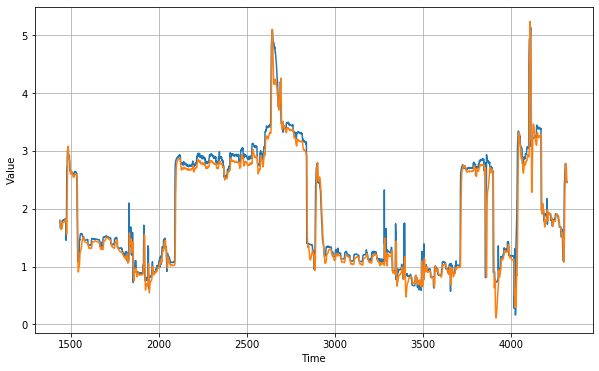

In [20]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [21]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

0.2314427

In [22]:
print(rnn_forecast)

[1.8001448 1.800267  1.7871253 ... 1.4209007 1.4270709 1.4647335]
